<a href="https://colab.research.google.com/github/grupomoura/ai_projects/blob/main/ResNet50_Fine_Tune_Base.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
files.upload()
!ls -lha kaggle.json
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
-rw-r--r-- 1 root root 66 May  8 22:44 kaggle.json


In [ ]:
!kaggle datasets download -d tommyngx/kneeoa

 99% 201M/204M [00:02<00:00, 99.6MB/s]
100% 204M/204M [00:02<00:00, 96.4MB/s]


In [ ]:
!cp /content/drive/MyDrive/Kaggle/Osteo2Class.zip .

In [ ]:
!unzip /content/Osteo2Class.zip #/content/kneeoa.zip

A saída de streaming foi truncada nas últimas 5000 linhas.
  inflating: Osteo2Class/train/1/9826718R.png  
  inflating: Osteo2Class/train/1/9833782L.png  
  inflating: Osteo2Class/train/1/9834325R.png  
  inflating: Osteo2Class/train/1/9859361L.png  
  inflating: Osteo2Class/train/1/9860356L.png  
  inflating: Osteo2Class/train/1/9860552L.png  
  inflating: Osteo2Class/train/1/9860552R.png  
  inflating: Osteo2Class/train/1/9860637R.png  
  inflating: Osteo2Class/train/1/9860831R.png  
  inflating: Osteo2Class/train/1/9861303R.png  
  inflating: Osteo2Class/train/1/9873823R.png  
  inflating: Osteo2Class/train/1/9874784R.png  
  inflating: Osteo2Class/train/1/9875724L.png  
  inflating: Osteo2Class/train/1/9875724R.png  
  inflating: Osteo2Class/train/1/9875794L.png  
  inflating: Osteo2Class/train/1/9877252L.png  
  inflating: Osteo2Class/train/1/9877252R.png  
  inflating: Osteo2Class/train/1/9890238R.png  
  inflating: Osteo2Class/train/1/9891264L.png  
  inflating: Osteo2Class/trai

# Imports

In [ ]:
# IMPORT MODULES
import sys
from os.path import join
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping


from keras import models, regularizers, layers, optimizers, losses, metrics
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import np_utils, to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image

from imblearn.over_sampling import RandomOverSampler 

#from keras.applications import ResNet50

import os

# Variáveis e verificação 

In [ ]:
PATH = "/content/"
print(os.listdir(PATH))
target_size=(224, 224)
img_size=224
model_name='ResNet50FineTune'
n_class=2


['.config', 'train', 'drive', 'test', 'Osteo_2Class.zip', 'val', 'sample_data']


In [ ]:
# Check content of the dirs

PATHtrain = PATH + 'train/'
print(len(os.listdir(PATHtrain)), " TRAIN Directories of photos")
Labels = os.listdir(PATHtrain)
sig = 0
for label in sorted(Labels):
    print(label,len(os.listdir(PATHtrain + label +'/')))
    sig = sig + len(os.listdir(PATHtrain + label +'/'))

print("Total TRAIN photos ", sig)
print("_"*50)

PATHvalid = PATH + 'val/'
print(len(os.listdir(PATHvalid)), " VALID Directories of photos")
Labels = os.listdir(PATHvalid)
sig = 0
for label in sorted(Labels):
    print(label,len(os.listdir(PATHvalid + label +'/')))
    sig = sig + len(os.listdir(PATHvalid + label +'/'))

print("Total Validation photos ", sig)
print("_"*50)

PATHtest = PATH + 'test/'
print(len(os.listdir(PATHtest)), " TEST Directories of photos")
Labels = os.listdir(PATHtest)
sig = 0
for label in sorted(Labels):
    print(label,len(os.listdir(PATHtest + label +'/')))
    sig = sig + len(os.listdir(PATHtest + label +'/'))

print("Total Testing photos ", sig)
print("_"*50)

2  TRAIN Directories of photos
0 2286
1 3492
Total TRAIN photos  5778
__________________________________________________
2  VALID Directories of photos
0 639
1 1017
Total Validation photos  1656
__________________________________________________
2  TEST Directories of photos
0 328
1 498
Total Testing photos  826
__________________________________________________


TRAIN  0  photo number  8


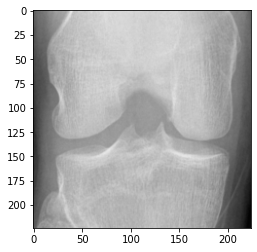

VALID  0  photo number  8


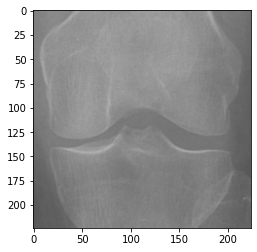

TEST  0  photo number  8


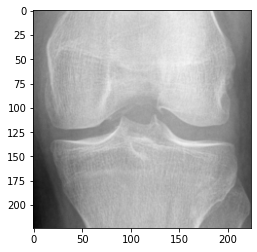

In [ ]:
# Check the photos and their labels 
TestNum = 8
diag = '0'

image_dir = PATHtrain +'/'+diag+'/'
img_name = os.listdir(image_dir)[TestNum]
img_path = image_dir+str(img_name)
img = image.load_img(img_path, target_size=target_size)
imgplot = plt.imshow(img)
print("TRAIN ",diag," photo number ", TestNum)
plt.show()

image_dir = PATHvalid +'/'+diag+'/'
img_name = os.listdir(image_dir)[TestNum]
img_path = image_dir+str(img_name)
img = image.load_img(img_path, target_size=target_size)
imgplot = plt.imshow(img)
print("VALID ",diag," photo number ", TestNum)
plt.show()

image_dir = PATHtest +'/'+diag+'/'
img_name = os.listdir(image_dir)[TestNum]
img_path = image_dir+str(img_name)
img = image.load_img(img_path, target_size=target_size)
imgplot = plt.imshow(img)
print("TEST ",diag," photo number ", TestNum)
plt.show()

# Image generator

In [ ]:
train_dir = PATHtrain
validation_dir = PATHvalid
test_dir = PATHtest
batch_size = 10

#train_datagen = ImageDataGenerator(rescale=1./255)
train_datagen = ImageDataGenerator(rescale=1./255,
                                  rotation_range=30,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  vertical_flip=True,
                                  fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,target_size=target_size,batch_size=batch_size)
validation_generator = test_datagen.flow_from_directory(
    validation_dir,target_size=target_size,batch_size=batch_size)
test_generator = test_datagen.flow_from_directory(
    test_dir,target_size=target_size,batch_size=batch_size)

Found 5778 images belonging to 2 classes.
Found 1656 images belonging to 2 classes.
Found 826 images belonging to 2 classes.


In [ ]:
print(train_generator.class_indices)
print(validation_generator.class_indices)
print(test_generator.class_indices)

{'0': 0, '1': 1}
{'0': 0, '1': 1}
{'0': 0, '1': 1}


In [ ]:
# Model save
my_callbacks = [
                ModelCheckpoint(filepath='/content/drive/MyDrive/IA_TRAINABLE/OSTEOPOROSES/callback_'+model_name+'_Osteo.h5', save_weights_only=True, monitor='val_accuracy', mode='max', save_best_only=True),
                ReduceLROnPlateau(monitor="loss", mode="auto", factor=0.02, patience=2, min_lr=0.00001),
                EarlyStopping(monitor="accuracy", patience=10, restore_best_weights=True)
                ]

# ResNet50 Fine Tune

In [ ]:
# Convoluted Base MODEL

conv_base = ResNet50(weights='imagenet',
include_top=False,
input_shape=(img_size, img_size, 3))

print(conv_base.summary())

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [ ]:
# MODEL

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.0001)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(n_class, activation='sigmoid'))

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
dropout (Dropout)            (None, 100352)            0         
_________________________________________________________________
dense (Dense)                (None, 64)                6422592   
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 130       
Total params: 30,010,434
Trainable params: 29,957,314
Non-trainable params: 53,120
_______________________________________

In [ ]:
# Make the conv_base NOT trainable:

for layer in conv_base.layers[:]:
   layer.trainable = False

print('conv_base is now NOT trainable')

conv_base is now NOT trainable


In [ ]:
for i, layer in enumerate(conv_base.layers):
   print(i, layer.name, layer.trainable)

In [ ]:
# Compile frozen conv_base + my top layer

model.compile(optimizer=optimizers.Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy'])


print(model.summary())

print("Model compiled!")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
dropout (Dropout)            (None, 100352)            0         
_________________________________________________________________
dense (Dense)                (None, 64)                6422592   
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 130       
Total params: 30,010,434
Trainable params: 6,422,722
Non-trainable params: 23,587,712
____________________________________

In [ ]:
print(train_generator.class_indices)
print(validation_generator.class_indices)
print(test_generator.class_indices)

{'0': 0, '1': 1}
{'0': 0, '1': 1}
{'0': 0, '1': 1}


577.8

In [ ]:
validation_generator.n

826

In [ ]:
# Short training ONLY my top layers 
#... so the conv_base weights will not be destroyed by the random intialization of the new weights

history = model.fit(train_generator,
                              epochs=3,
                              steps_per_epoch = train_generator.n // batch_size,
                              validation_data = validation_generator,
                              validation_steps = validation_generator.n // batch_size,
                              callbacks = my_callbacks
                              )

Epoch 1/5
577/577 [==============================] - 72s 125ms/step - loss: 0.6720 - accuracy: 0.6044 - val_loss: 0.6721 - val_accuracy: 0.6037
Epoch 2/5
577/577 [==============================] - 71s 124ms/step - loss: 0.6718 - accuracy: 0.6045 - val_loss: 0.6716 - val_accuracy: 0.6049
Epoch 3/5
577/577 [==============================] - 71s 123ms/step - loss: 0.6718 - accuracy: 0.6044 - val_loss: 0.6725 - val_accuracy: 0.6024
Epoch 4/5
577/577 [==============================] - 71s 122ms/step - loss: 0.6717 - accuracy: 0.6044 - val_loss: 0.6724 - val_accuracy: 0.6024
Epoch 5/5
577/577 [==============================] - 71s 123ms/step - loss: 0.6744 - accuracy: 0.6040 - val_loss: 0.6717 - val_accuracy: 0.6049


In [ ]:
# Make last block of the conv_base trainable:

for layer in conv_base.layers[:165]:
   layer.trainable = False
for layer in conv_base.layers[165:]:
   layer.trainable = True

print('Last block of the conv_base is now trainable')

In [ ]:
for i, layer in enumerate(conv_base.layers):
   print(i, layer.name, layer.trainable)

In [ ]:
# Compile frozen conv_base + UNfrozen top block + my top layer ... SLOW LR

model.compile(optimizer=optimizers.Adam(lr=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])


print(model.summary())
print("model compiled!")

In [ ]:
# Long training with fine tuning

history = model.fit(train_generator,
                              epochs=25,
                              steps_per_epoch = train_generator.n // batch_size,
                              validation_data = validation_generator,
                              validation_generator.n // batch_size,
                              callbacks = my_callbacks
                    )

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
test_loss, test_acc = model.evaluate_generator(test_generator, steps=test_generator.n // batch_size, verbose=1)
print('test acc:', test_acc)

In [ ]:
# SAVE model
model.save('/content/drive/MyDrive/IA_TRAINED/OSTEOPOROSES/OsteoResNet50FineTune.h5')
print("OsteoResNet50FineTune.h5 was saved")